In [2]:
import sys
import os
import pandas as pd
# Add the source directory to the system path
sys.path.append(os.path.abspath('../src'))
from open_data import fetch_db_table_sqlserver16
import matplotlib.pyplot as plt

# SQL query to fetch data
sql_query = "SELECT * FROM TERNA_SUNSET_SEGNO_QH" 
qh = fetch_db_table_sqlserver16(sql=sql_query, verbose=False)
qh = qh.sort_values(by='ORAINI')

qh.head()

c:\imbalance_forecast\src\open_data.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con, params=parameters)


,MACROZONA,ORAINI,FLOWDATE,FLOWHOUR,SBIL_MWH,SEGNO,SCAMBI_MWH,ESTERO_MWH,LOADTIME
444,SUD,202410020000,20241002,1,123.741,+,497.952,202.968,2024-10-03 19:02:09.760
114,NORD,202410020000,20241002,1,-64.945,-,-497.952,1396.755,2024-10-03 19:02:09.760
115,NORD,202410020015,20241002,1,-97.201,-,-670.762,1512.663,2024-10-03 19:02:09.760
445,SUD,202410020015,20241002,1,3.721,+,670.762,202.572,2024-10-03 19:02:09.760
446,SUD,202410020030,20241002,1,57.589,+,642.520,203.779,2024-10-03 19:02:09.760


In [3]:

# Filter the DataFrame for the relevant columns and rows
qh = qh[['MACROZONA', 'ORAINI', 'SBIL_MWH']]
# Convert ORAINI to datetime using the correct method
qh['ORAINI'] = pd.to_datetime(qh['ORAINI'], format='%Y%m%d%H%M')

# Nord
qh_nord = qh[qh['MACROZONA'] == 'NORD']

# Sud
qh_sud = qh[qh['MACROZONA'] == 'SUD']

# Print the first few rows of the DataFrame
qh_nord.head()

,MACROZONA,ORAINI,SBIL_MWH
114,NORD,2024-10-02 00:00:00,-64.945
115,NORD,2024-10-02 00:15:00,-97.201
116,NORD,2024-10-02 00:30:00,-57.011
117,NORD,2024-10-02 00:45:00,8.936
118,NORD,2024-10-02 01:00:00,-75.246


In [4]:
qh_sud.head()

,MACROZONA,ORAINI,SBIL_MWH
444,SUD,2024-10-02 00:00:00,123.741
445,SUD,2024-10-02 00:15:00,3.721
446,SUD,2024-10-02 00:30:00,57.589
447,SUD,2024-10-02 00:45:00,98.611
448,SUD,2024-10-02 01:00:00,27.640


# System Imbalance
This section analyzes the quarterly hours of system imbalance in the Italian electricity market, focusing on the characteristics of imbalances in the northern and southern macrozones.


### Nord

In [5]:
print("Macro-scale descriptive stats:")
print(qh_nord["SBIL_MWH"].describe(),"\n")

Macro-scale descriptive stats:
count    1284.000000
mean       16.210450
std       148.522269
min      -542.245000
25%       -82.514250
50%        18.797500
75%       104.969500
max      1348.011000
Name: SBIL_MWH, dtype: float64 



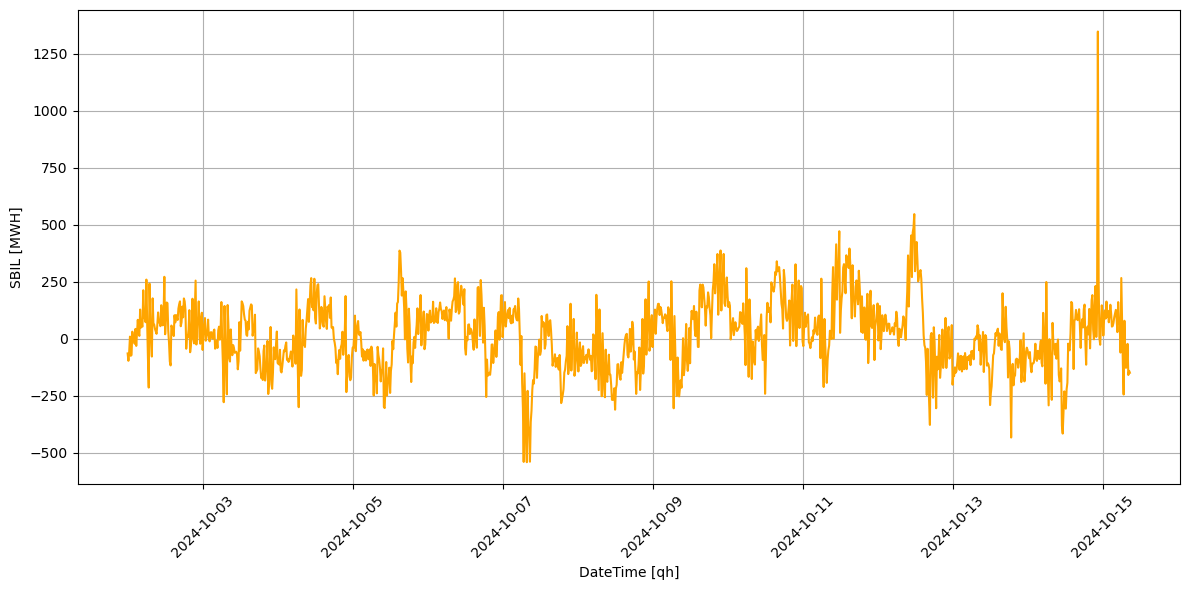

In [6]:
# Plotting SBIL_MWH over ORAINI
plt.figure(figsize=(12, 6)) 
plt.plot(qh_nord['ORAINI'], qh_nord['SBIL_MWH'], linestyle='-', color='orange')
plt.xlabel('DateTime [qh]') 
plt.ylabel('SBIL [MWH]') 
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid() 
plt.tight_layout()  
plt.show()  

<h3>KDE</h3>

The Kernel Density Estimator (KDE) provides a rational and visually pleasant representation of the data distribution, even if the data distribution is too irregular and does not resemble any of the usual PDFs

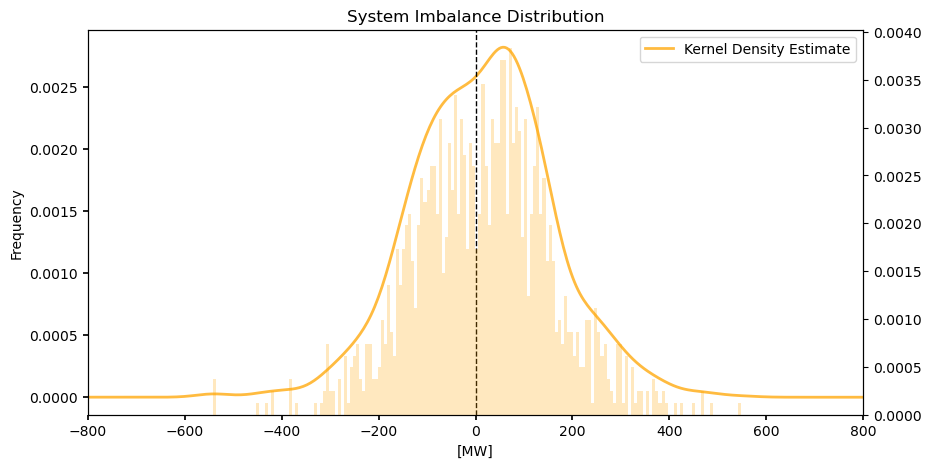

In [7]:
# Parameters
n_bins = 300  
DPI = 100  

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)

# Plot Kernel Density Estimate (KDE)
qh_nord.plot(y="SBIL_MWH", ax=ax, kind="kde", color='orange', alpha=0.75,
        linewidth=2, label="Kernel Density Estimate")

# Plot Histogram
qh_nord.plot(y="SBIL_MWH", ax=ax, kind="hist", bins=n_bins, alpha=0.25,
        density=True, color='orange', label=f"Histogram ({n_bins} bins)",
        secondary_y=True)

# Set title and labels
ax.set_title("System Imbalance Distribution")
ax.set_xlabel("[MW]")

# Set x-limits for better visibility
ax.set_xlim(-800, 800)

# Customize ticks
ax.tick_params(width=1.25)

# Add a vertical line at x=0
ax.axvline(0, color='black', ls='--', linewidth=1, alpha=1)

# Display legend
ax.legend(loc='upper right')

# Show the plot
plt.show()

<h3> QQ-plot </h3>

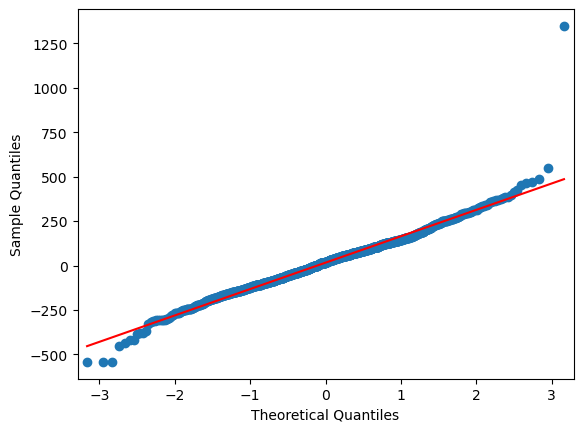

In [22]:
import numpy as np 
import statsmodels.api as sm 
import pylab as py 

sm.qqplot(qh_nord["SBIL_MWH"], line='s')

py.show()

In [9]:
from scipy.stats import kstest, norm
my_data = norm.rvs(size=1000)
ks_statistic, p_value = kstest(qh_nord["SBIL_MWH"], cdf="norm")
print(ks_statistic, p_value)

0.5383087429705837 0.0


<h3>Hourly Distribution </h3>

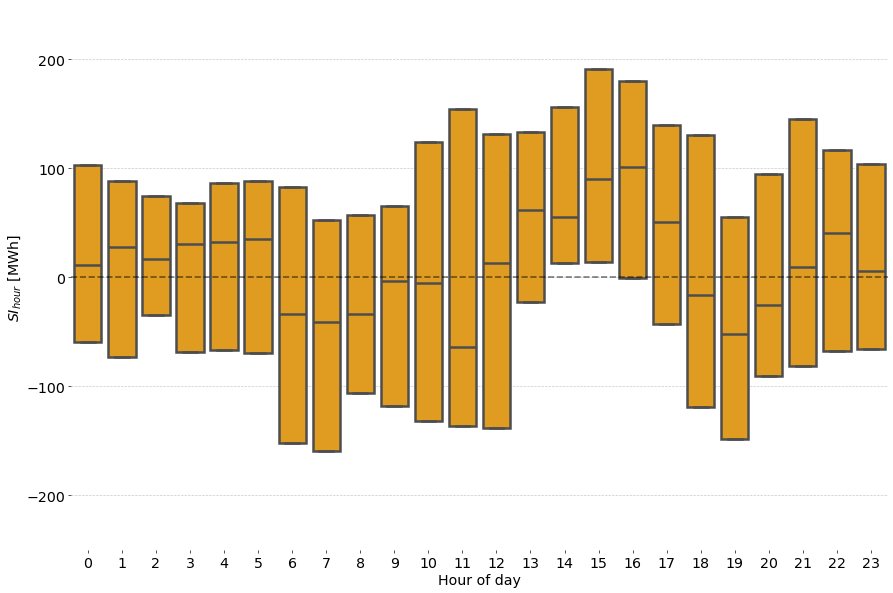

In [20]:
import seaborn as sns

# Extract hour from ORAINI column
qh_nord.loc[:, 'hour'] = qh_nord['ORAINI'].dt.hour

# Set DPI for better image quality
DPI = 60  

fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)

# Boxplot for SBIL_MWH over the hours with increased linewidth for the box borders
sns.boxplot(data=qh_nord, x="hour", y="SBIL_MWH", fliersize=0, whis=0, color='orange', linewidth=3)

ax.tick_params(axis="both", which="major", labelsize=17)
ax.tick_params(axis="both", which="minor", labelsize=17)
ax.set_xlabel("Hour of day", fontsize=17)
ax.set_ylabel("$SI_{hour}$ [MWh]", fontsize=17)

# Set background colors
fig.set(facecolor="#FFFFFF")
ax.set(facecolor="#FFFFFF")

# Hide specific plot spines
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Add horizontal line at y=0
ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)

# Add horizontal grid lines
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust the y-axis limits
plt.ylim([-250, 250])

plt.tight_layout()

# Show the plot
plt.show()

This plot seems to reflect higher negative imbalance at times of high load: in the afternoon (16:00-21:00), and somewhat during the morning too (6:00-9:00).

<h3>Volume over time</h3>

In [23]:
def calculate_imbalance_volume(group, how="sum"):
    if how == "sum":
        return group.abs().sum()*0.25*1e-3  # To obtain GWh (multiply by 1/4 h)
    elif how=="mean":
        return group.abs().mean() # To obtain average MW

Mancano ancora molti dati!

In [29]:
'''
qh_nord['year'] = qh_nord['ORAINI'].dt.year
qh_nord['month'] = qh_nord['ORAINI'].dt.month

# Group by year and month, then apply the custom imbalance volume calculation
agg_month = (
    qh_nord
    .groupby(by=["year", "month"])["SBIL_MWH"]
    .apply(calculate_imbalance_volume, how="sum")
)

# Adjust the date index range for the aggregated data
agg_month.index = pd.date_range(
    start=pd.Timestamp(f"{agg_month.index[0][0]}-{agg_month.index[0][1]}") - pd.DateOffset(months=0),
    end=pd.Timestamp(f"{agg_month.index[-1][0]}-{agg_month.index[-1][1]}") + pd.DateOffset(months=0),
    freq="1MS"
)

rolling_window = 12

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=[18, 6], dpi=DPI, sharex=True, sharey=True)

# Plot original monthly imbalance volume on the first subplot
agg_month.plot(ax=ax[0],
               ylabel="[GWh]",
               c="orange",
               linewidth=2.5,  # Increased linewidth for better visibility
               title=f"Evolution of monthly |SI| volumes")
agg_month.plot(ax=ax[0],
               style=".",
               color="orange",
               markersize=10)

# Plot rolling mean with the specified rolling window on the second subplot
agg_month.rolling(rolling_window, center=True).mean().plot(ax=ax[1],
                                                           ylabel="[GWh]",
                                                           c="orange",
                                                           linewidth=3,  # Increased line thickness for rolling average
                                                           title=f"Evolution of monthly |SI| volumes, {rolling_window}-month moving average")

# Set the y-axis limits dynamically based on the maximum value
plt.ylim(0, 1.25 * agg_month.max())

# Add grid lines and remove unnecessary spines (border lines)
#my_plots.despine(ax[0], grid=True)
#my_plots.despine(ax[1], grid=True)

# Enable horizontal grid lines
ax[0].grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid to first plot
ax[1].grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid to second plot

# Automatically adjust x-axis label formatting
fig.autofmt_xdate()

# Display the plot
plt.show()
'''

'\nqh_nord[\'year\'] = qh_nord[\'ORAINI\'].dt.year\nqh_nord[\'month\'] = qh_nord[\'ORAINI\'].dt.month\n\n# Group by year and month, then apply the custom imbalance volume calculation\nagg_month = (\n    qh_nord\n    .groupby(by=["year", "month"])["SBIL_MWH"]\n    .apply(calculate_imbalance_volume, how="sum")\n)\n\n# Adjust the date index range for the aggregated data\nagg_month.index = pd.date_range(\n    start=pd.Timestamp(f"{agg_month.index[0][0]}-{agg_month.index[0][1]}") - pd.DateOffset(months=0),\n    end=pd.Timestamp(f"{agg_month.index[-1][0]}-{agg_month.index[-1][1]}") + pd.DateOffset(months=0),\n    freq="1MS"\n)\n\nrolling_window = 12\n\n# Create subplots\nfig, ax = plt.subplots(1, 2, figsize=[18, 6], dpi=DPI, sharex=True, sharey=True)\n\n# Plot original monthly imbalance volume on the first subplot\nagg_month.plot(ax=ax[0],\n               ylabel="[GWh]",\n               c="orange",\n               linewidth=2.5,  # Increased linewidth for better visibility\n               ti

<h3> ACF </h3>

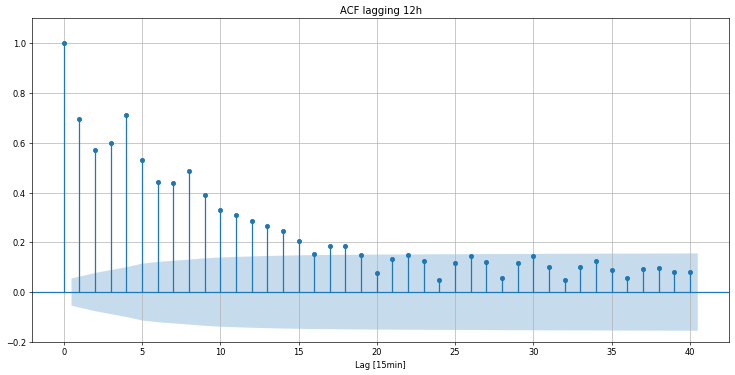

In [30]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(qh_nord["SBIL_MWH"], alpha=.05, lags=4*10,
                         ax=ax, title="ACF lagging 12h")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [15min]')
plt.grid()
plt.show()

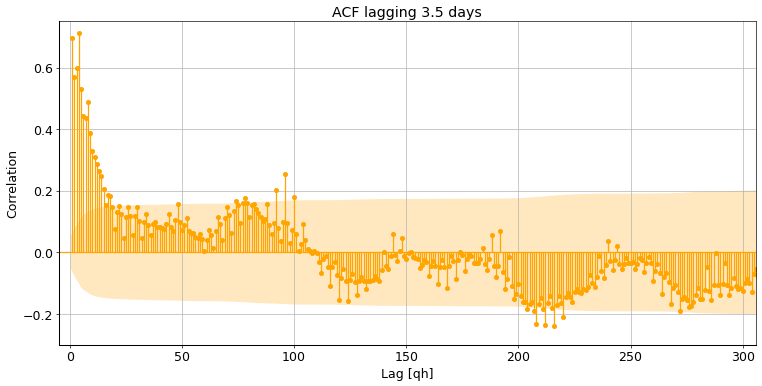

In [39]:
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(qh_nord["SBIL_MWH"], alpha=.05, lags=4*24*3.5,
                         zero=False,
                         ax=ax,
                         color="orange", vlines_kwargs={"colors": "orange"})

ax.set_title("ACF lagging 3.5 days", fontsize=17)
plt.ylim(-0.3, 0.75)
plt.xlim(-5, 4*24*3.5-30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Lag [qh]", fontsize=15)
ax.spines["left"].set_linewidth(1.25)
ax.spines["bottom"].set_linewidth(1.25)
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor("orange")
plt.grid()
plt.show()


Autocorrelation function plot of system imbalance, with lags reaching up to three days in the past. Lag-0 is omitted.